In [1]:
%matplotlib inline
import sys
from scipy import stats
from collections import defaultdict, Counter
from scipy import spatial
import numpy as np
import pylab as plt
import scipy.stats as ss
import statsmodels.api as sm
from scipy.stats.stats import pearsonr
import json
import random
import itertools
from sklearn.manifold import TSNE
from copy import deepcopy
import time
import scipy as sp
from scipy.sparse import csr_matrix
import matplotlib.cm as cm
from numpy.random import choice
import itertools
import operator
from sklearn import manifold
import pandas as pd
from sklearn.cluster import KMeans
import statsmodels.api as sm


def OLSRegressFit(x,y): # fitting regression 
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    return [constant, beta, r2]

def flushPrint(d): # counter
    sys.stdout.write('\r')
    sys.stdout.write(str(d))
    sys.stdout.flush()
    
def default_to_regular(d): # convert default dict to regular dict
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

In [ ]:
# data downloaded from https://www.kaggle.com/nsharan/h-1b-visa/version/2
#
# see https://sharan-naribole.github.io/2017/02/24/h1b-eda-part-I.html for data cleaning
# and https://github.com/sharan-naribole/H1B_visa_eda/blob/master/data_processing.Rmd
# for more informtation on this dataset, and 
# https://quanwei.tech/ for an online version

# Time Series Demo

In [243]:
df=pd.read_csv("/Users/lingfeiw/Documents/teaching/INFOVIZ/futureHacking/h1b_kaggle.csv",
               header='infer',delimiter=",",encoding = "ISO-8859-1")
df=df.dropna() # this drop rows with nan values in any column, for formal analysis do it for specifici columns

In [244]:
df.columns

Index(['Unnamed: 0', 'CASE_STATUS', 'EMPLOYER_NAME', 'SOC_NAME', 'JOB_TITLE',
       'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR', 'WORKSITE', 'lon',
       'lat'],
      dtype='object')

In [4]:
len(df)

2877765

### 1. The growth of applications 

In [5]:
S=defaultdict(lambda:defaultdict(lambda:0))
for y,s in zip(df['YEAR'],df['CASE_STATUS']):
    S[s.lower()][int(y)]+=1
    
status=list(S.keys())
# In analysis we find 'rejected', 'invalidated', and 'pending quality and compliance review - unassigned' 
# are very rare, therefore, we would not visualize them

### 1.1 lineChart

(0, 600000)

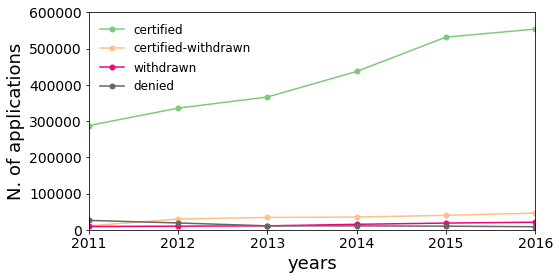

In [6]:
cmap = cm.get_cmap('Accent',4)
fig = plt.figure(figsize=(8, 4),facecolor='white')
ax = fig.add_subplot(111)
n=0
for i in ['certified','certified-withdrawn','withdrawn','denied']:
    x,y=np.array(sorted(S[i].items())).T
    plt.plot(x,y,color=cmap(n),label=i,marker='o',markersize=5)
    n+=1
ax.legend(loc=2,numpoints=1,fontsize=12,frameon=False)
plt.xlabel('years',fontsize=18)
plt.ylabel('N. of applications',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(2011,2016)
plt.ylim(0,600000)

### 1.2 barChart

(0, 600000)

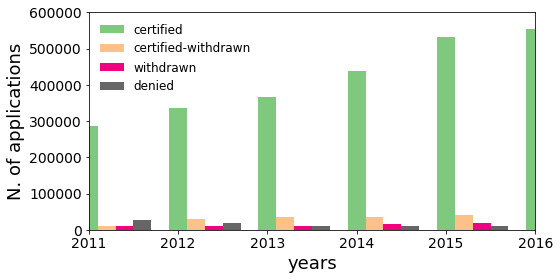

In [233]:
cmap = cm.get_cmap('Accent',4)
fig = plt.figure(figsize=(8, 4),facecolor='white')
ax = fig.add_subplot(111)
deltaX=0.2
n=0
for i in ['certified','certified-withdrawn','withdrawn','denied']:
    x,y=np.array(sorted(S[i].items())).T
    ax.bar(x+deltaX*n,y,width=deltaX,color=cmap(n),label=i)
    n+=1
plt.xlabel('years',fontsize=18)
plt.ylabel('N. of applications',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc=2,numpoints=1,fontsize=12,frameon=False)
plt.xlim(2011,2016)
plt.ylim(0,600000)

### 2. Top employers

In [7]:
E=defaultdict(lambda:defaultdict(lambda:0))
for y,s in zip(df['YEAR'],df['EMPLOYER_NAME']):
    E[s][int(y)]+=1

In [8]:
total=[(k,sum(v.values())) for k,v in E.items()]
topCom=sorted(total,key=lambda x:x[1],reverse=True)[:10]

In [9]:
topCom

[('INFOSYS LIMITED', 130257),
 ('TATA CONSULTANCY SERVICES LIMITED', 64273),
 ('WIPRO LIMITED', 45673),
 ('DELOITTE CONSULTING LLP', 35999),
 ('IBM INDIA PRIVATE LIMITED', 33585),
 ('ACCENTURE LLP', 33226),
 ('MICROSOFT CORPORATION', 25551),
 ('HCL AMERICA, INC.', 22488),
 ('ERNST & YOUNG U.S. LLP', 18094),
 ('COGNIZANT TECHNOLOGY SOLUTIONS U.S. CORPORATION', 17322)]

### 2.1 lineChart

(0, 60000)

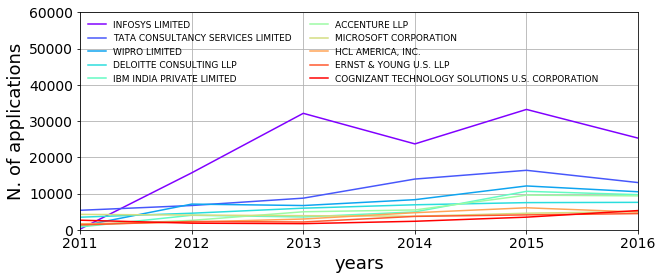

In [10]:
cmap = cm.get_cmap('rainbow',len(topCom))
fig = plt.figure(figsize=(10, 4),facecolor='white')
ax = fig.add_subplot(111)
n=0
for name,totalN in topCom:
    x,y=np.array(sorted(E[name].items())).T
    plt.plot(x,y,color=cmap(n),label=name,marker='',markersize=5)
    n+=1
ax.legend(loc=2,numpoints=1,fontsize=9,frameon=False,ncol=2)
plt.xlabel('years',fontsize=18)
plt.ylabel('N. of applications',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
plt.xlim(2011,2016)
plt.ylim(0,60000)

### 2.2 ThemeRiver

In [247]:
# from http://leebyron.com/streamgraph/stackedgraphs_byron_wattenberg.pd
# Based on http://code.activestate.com/recipes/576633/
# which is based on:
# Reference: 'Stacked graphs- geometry & aesthetics' by Byron and Wattenberg
# http://www.leebyron.com/else/streamgraph/download.php?file=stackedgraphs_byron_wattenberg.pdf

import numpy as np
import matplotlib.pyplot as plt

# baseline functions
def baseline_symmetric(streams):
    """Symmetric baseline ('silhouette')"""
    g0 = -0.5 * np.sum(np.asarray(streams),axis=0)
    return g0

def baseline_zero(streams):
    """Zero baseline"""
    return np.zeros(np.asarray(streams).shape[1])

def baseline_weighted_wiggle(streams):
    """Weighted-wiggle minimization
    
    NOTE: streams should already be ordered as desired
    """
    streams = np.asarray(streams)
    
    # add a column of zeros on the left side of streams
    f = np.hstack( (np.zeros((streams.shape[0],1)),streams) )
    dff = np.diff(f)
    cum_sum_dff = np.vstack( (np.zeros((1,dff.shape[1])),np.cumsum(dff,axis=0)) )[:-1,:]
    dg0 = (-1./np.sum(streams,axis=0)) * np.sum((0.5 * dff + cum_sum_dff) * streams,axis=0)
    g0 = np.cumsum(dg0)
    return g0

# ordering functions
def argsort_onset(streams):
    """Returns permutation indices (like argsort) for onset ordering."""
    streams = np.asarray(streams)
    nonzero_idxs = [np.arange(streams.shape[1])[idxs] for idxs in (streams > 0)]
    onset_idxs = [np.min(nzi) if len(nzi) > 0 else streams.shape[1] for nzi in nonzero_idxs]
    return np.argsort(onset_idxs)

def argsort_inside_out(streams):
    """Returns permutation indices (like argsort) for inside-out ordering."""
    upper = []
    lower = []
    weight_up = 0
    weight_lo = 0
    for (i,stream) in enumerate(streams):
        if weight_up < weight_lo:
            upper.append(i)
            weight_up += np.sum(stream)
        else:
            lower.append(i)
            weight_lo += np.sum(stream)
    
    return upper[::-1] + lower

def streamgraph(ax, streams, x=None, colors=None, baseline=baseline_weighted_wiggle, yoffset=0., whitebg=True):
    streams = np.asarray(streams)
    
    g0 = baseline(streams) + yoffset
    
    if x == None:
        x = range(streams.shape[1])
    
    if colors == None:
        colors = list(map(cm.get_cmap('Accent'),np.random.uniform(size=streams.shape[0])))
    
    layers = []
    g_lo = g0
    for stream in streams:
        g_hi = g_lo + stream
        verts_lo = list(zip(x,g_lo))
        verts_hi = list(zip(x[::-1],g_hi[::-1]))
        layer = verts_lo + verts_hi
        layers.append(layer)
        g_lo = g_hi
    
    polys = mpl.collections.PolyCollection(layers,facecolors=colors,linewidths=0, zorder=0)
    ax.add_collection(polys)
    
#     # add an opaque white background to the streamgraph
#     if whitebg == True:
#         verts = np.asarray(list(zip(x,g0)) + list(zip(x[::-1],g_hi[::-1])))
#         bglayer = mpl.patches.Polygon(verts, closed=True, color='white', alpha=1, zorder=5)
#         ax.add_patch(bglayer)
    
    return ax

def format_streamgraph(ax):
    """Performs some common formatting operations for streamgraphs"""
    # kill the frame
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # set ticks
    ax.xaxis.set_ticks_position('bottom')


(2011, 2016)

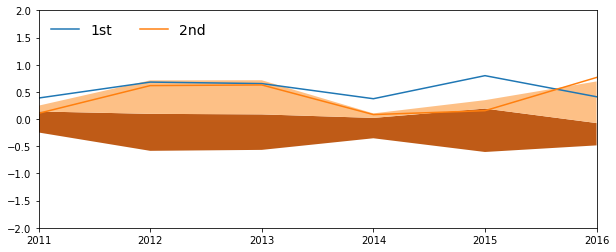

In [248]:
#test
N=6
streams=[[random.random() for i in range(N)],[random.random() for i in range(N)]]
streams=np.array(streams)

fig = plt.figure(figsize=(10, 4),facecolor='white')
ax = fig.add_subplot(111)
streamgraph(ax,streams,x=range(2011,2017))
plt.plot(range(2011,2017),streams[0],label='1st',zorder=1)
plt.plot(range(2011,2017),streams[1],label='2nd',zorder=1)
ax.legend(loc=2,numpoints=1,fontsize=14,frameon=False,ncol=2)
plt.ylim(-2,2)
plt.xlim(2011,2016)

(-60000, 60000)

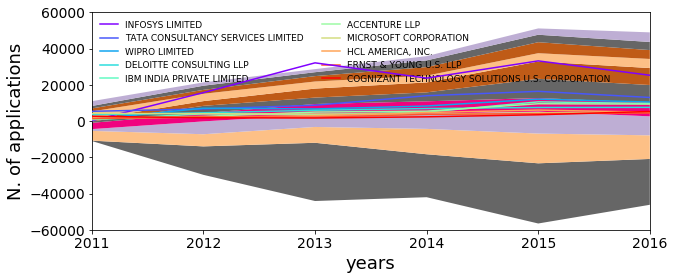

In [225]:
fig = plt.figure(figsize=(10, 4),facecolor='white')
ax = fig.add_subplot(111)
#
streams=np.array([[E[name][y] for y in range(2011,2017)] for name,totalN in topCom])
streamgraph(ax,streams,x=range(2011,2017))
#plt.ylim(-2,2)

cmap = cm.get_cmap('rainbow',len(topCom))

n=0
for name,totalN in topCom:
    x,y=np.array(sorted(E[name].items())).T
    plt.plot(x,y,color=cmap(n),label=name,marker='',markersize=5,zorder=11)
    n+=1
ax.legend(loc=2,numpoints=1,fontsize=9,frameon=False,ncol=2)
plt.xlabel('years',fontsize=18)
plt.ylabel('N. of applications',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.xlim(2011,2016)
plt.ylim(-60000,60000)

### timeWheel

In [239]:
import calendar

In [235]:
# generate the table with timestamps
np.random.seed(1)
times = pd.Series(pd.to_datetime("Nov 1 '16 at 0:42") + pd.to_timedelta(np.random.rand(10000)*60*24*40, unit='m'))
# generate counts of each (weekday, hour)
data = pd.crosstab(times.dt.weekday, times.dt.hour.apply(lambda x: '{:02d}:00'.format(x))).fillna(0)
data.index = [calendar.day_name[i][0:3] for i in data.index]
print(data.T)

       Mon  Tue  Wed  Thu  Fri  Sat  Sun
col_0                                   
00:00   55   56   67   60   60   62   45
01:00   51   65   70   65   60   59   40
02:00   47   76   67   68   61   63   51
03:00   51   71   62   72   53   73   58
04:00   41   63   59   64   68   63   61
05:00   37   61   73   64   68   68   49
06:00   58   67   63   81   58   53   39
07:00   39   62   76   48   56   78   48
08:00   52   46   61   64   63   61   50
09:00   54   86   59   57   66   65   57
10:00   70   68   54   68   52   71   58
11:00   60   68   64   59   60   50   59
12:00   53   53   69   60   58   58   56
13:00   53   66   53   60   70   67   46
14:00   41   77   73   82   49   62   53
15:00   48   66   64   76   69   72   44
16:00   41   62   58   64   48   57   48
17:00   54   48   69   70   56   51   61
18:00   57   61   61   52   71   51   47
19:00   49   71   52   59   70   68   62
20:00   45   63   65   82   57   60   63
21:00   45   59   56   53   67   56   56
22:00   51   51 

In [236]:
# make a heatmap building function 
def pie_heatmap(table, cmap=cm.hot, vmin=None, vmax=None,inner_r=0.25, pie_args={}):
    n, m = table.shape
    vmin= table.min().min() if vmin is None else vmin
    vmax= table.max().max() if vmax is None else vmax

    centre_circle = plt.Circle((0,0),inner_r,edgecolor='black',facecolor='white',fill=True,linewidth=0.25)
    plt.gcf().gca().add_artist(centre_circle)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    for i, (row_name, row) in enumerate(table.iterrows()):
        labels = None if i > 0 else table.columns
        wedges = plt.pie([1] * m,radius=inner_r+float(n-i)/n, colors=[cmapper.to_rgba(x) for x in row.values], 
            labels=labels, startangle=90, counterclock=False, wedgeprops={'linewidth':-1}, **pie_args)
        plt.setp(wedges[0], edgecolor='white',linewidth=1.5)
        wedges = plt.pie([1], radius=inner_r+float(n-i-1)/n, colors=['w'], labels=[row_name], startangle=-90, wedgeprops={'linewidth':0})
        plt.setp(wedges[0], edgecolor='white',linewidth=1.5)

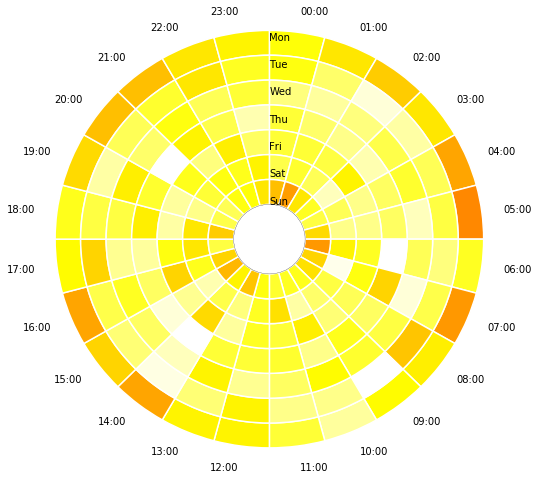

In [238]:
# test
plt.figure(figsize=(8,8))
pie_heatmap(data, vmin=-20,vmax=80,inner_r=0.2)
plt.show();

In [240]:
status

['certified-withdrawn',
 'withdrawn',
 'certified',
 'denied',
 'rejected',
 'invalidated',
 'pending quality and compliance review - unassigned']

In [274]:
J=defaultdict(lambda:defaultdict(lambda:0))
for y,s in zip(df['YEAR'],df['SOC_NAME']):
    J[s.lower()][int(y)]+=1

In [279]:
totalJ=[(k,sum(v.values())) for k,v in J.items()]
topJob=sorted(totalJ,key=lambda x:x[1],reverse=True)[:24]

In [280]:
topJob

[('computer systems analysts', 499177),
 ('software developers, applications', 408896),
 ('computer programmers', 392036),
 ('computer occupations, all other', 175934),
 ('software developers, systems software', 82644),
 ('management analysts', 65329),
 ('financial analysts', 52571),
 ('accountants and auditors', 50613),
 ('mechanical engineers', 40778),
 ('network and computer systems administrators', 39236),
 ('database administrators', 38160),
 ('market research analysts and marketing specialists', 36201),
 ('electronics engineers, except computer', 35962),
 ('operations research analysts', 33605),
 ('computer software engineers, applications', 32825),
 ('electrical engineers', 32353),
 ('physicians and surgeons, all other', 30334),
 ('computer and information systems managers', 27004),
 ('computer occupations, all other*', 25928),
 ('medical scientists, except epidemiologists', 25714),
 ('biochemists and biophysicists', 21017),
 ('computer systems analyst', 17364),
 ('industrial en

In [332]:
d=np.array([[J[j][y] for y in range(2011,2017)] for j,f in topJob]).T
d=np.log(d+1)
d=pd.DataFrame(d)
d.columns=list(zip(*topJob))[0]
d.rename(index={i-2011:i for i in range(2011,2017)}, inplace=True)

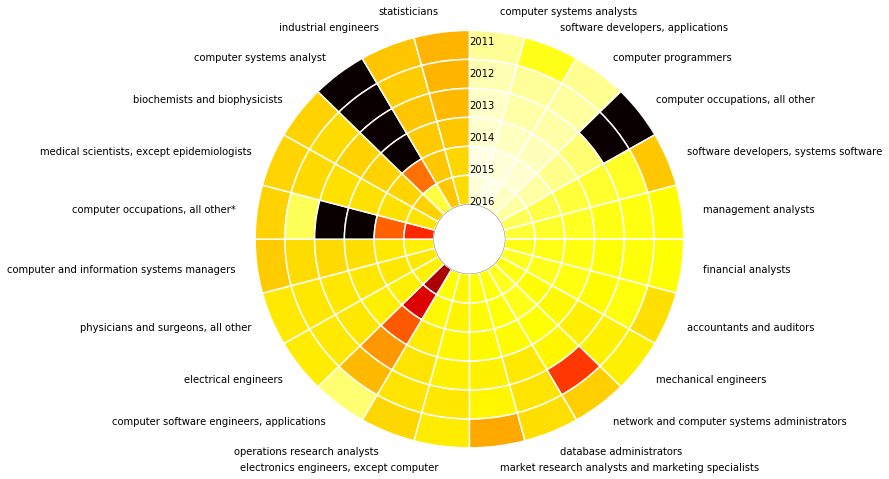

In [333]:
plt.figure(figsize=(8,8))
pie_heatmap(d, vmin=0,vmax=12,inner_r=0.2)
plt.show();